# Naive Bayes Spam Classifier

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import os

## 1. Load and Prepare Data

In [33]:
base_dir = os.getcwd()
data_path = os.path.join(base_dir, "data", "SMSSpamCollection")
df = pd.read_csv(data_path, sep='\t', header=None, names=['label', 'message'])

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (5572, 2)

First few rows:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [34]:
# missing value handeling

df.isna().sum()

label      0
message    0
dtype: int64

In [35]:
# Preprocessing

import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['message'].apply(clean_text)
df.head()

,label,message,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...","go jurong point, crazy.. available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor... u c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah think goes usf, lives around though"


## 2. Split Data into Training and Testing Sets

Split the data into 70% training and 30% testing. The `stratify` parameter ensures both sets have the same spam/ham ratio, which is crucial for imbalanced datasets.

In [36]:
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTraining distribution:\n{train_df['label'].value_counts()}")
print(f"\nTest distribution:\n{test_df['label'].value_counts()}")

Training samples: 3900
Test samples: 1672

Training distribution:
label
ham     3377
spam     523
Name: count, dtype: int64

Test distribution:
label
ham     1448
spam     224
Name: count, dtype: int64


* Label distribution

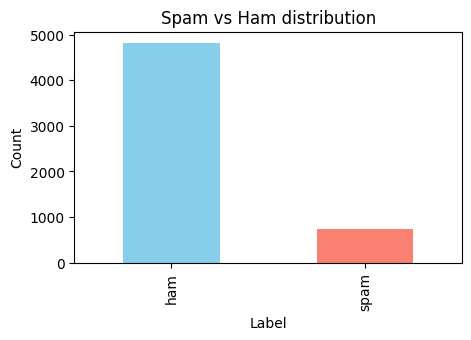

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
df['label'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Spam vs Ham distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## 3. Text Vectorization

`CountVectorizer` converts text documents into a matrix of token counts. It handles:
- **Tokenization**: Splitting sentences into words
- **Lowercasing**: Normalizing case
- **Stop words**: Removing common words (optional)

We'll fit it on the training data only to avoid data leakage, then transform both spam and ham separately.

In [48]:
# Initialize vectorizer (removes common English stop words)
vectorizer = CountVectorizer(stop_words='english')

# Fit on all training data and transform
X_train_counts = vectorizer.fit_transform(train_df['clean_text'])

# Get feature names (unique words)
feature_names = vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(feature_names)}")
print(f"Sample features: {feature_names[:10]}")

# Separate spam and ham matrices
spam_matrix = vectorizer.transform(train_df[train_df['label'] == 'spam']['message'])
ham_matrix = vectorizer.transform(train_df[train_df['label'] == 'ham']['message'])

Vocabulary size: 6854
Sample features: ['00' '000' '000pes' '008704050406' '0089' '0121' '01223585334' '02'
 '0207' '02072069400']


## 4. Calculate Class Priors

The prior probability is simply the proportion of each class in the training data.

In [39]:
# Calculate prior probabilities
p_spam = len(train_df[train_df['label'] == 'spam']) / len(train_df)
p_ham = len(train_df[train_df['label'] == 'ham']) / len(train_df)

print(f"P(Spam) = {p_spam:.4f}")
print(f"P(Ham)  = {p_ham:.4f}")

P(Spam) = 0.1341
P(Ham)  = 0.8659


## 5. Calculate Word Conditional Probabilities

For each word, we calculate:
- **Spamicity**: Probability word appears in a spam email
- **Hamicity**: Probability word appears in a ham email

We use **Laplace smoothing** (add-1 smoothing) to handle unseen words and avoid zero probabilities:
```
P(word|Spam) = (spam_emails_with_word + 1) / (total_spam_emails + 2)
```

We count **documents** containing each word, not raw frequency, following the Bernoulli Naive Bayes model.

In [40]:
# Initialize probability dictionaries
spamicity = {}
hamicity = {}

# Calculate for each word in vocabulary
for idx, word in enumerate(feature_names):
    # Count documents containing the word
    spam_docs_with_word = (spam_matrix[:, idx].toarray() > 0).sum()
    ham_docs_with_word = (ham_matrix[:, idx].toarray() > 0).sum()
    
    # Apply Laplace smoothing
    spamicity[word] = (spam_docs_with_word + 1) / (spam_matrix.shape[0] + 2)
    hamicity[word] = (ham_docs_with_word + 1) / (ham_matrix.shape[0] + 2)

print("Sample probabilities:")
for word in ['password', 'website', 'free', 'hi'][:4]:
    print(f"'{word}': Spamicity={spamicity[word]:.4f}, Hamicity={hamicity[word]:.4f}")

Sample probabilities:
'password': Spamicity=0.0076, Hamicity=0.0009
'website': Spamicity=0.0038, Hamicity=0.0015
'free': Spamicity=0.2305, Hamicity=0.0118
'hi': Spamicity=0.0248, Hamicity=0.0228


## 6. Prediction Function

Our `predict()` function:
1. Vectorizes the input email
2. Calculates **log probabilities** to prevent numerical underflow
3. Multiplies probabilities (adds logs) for all words
4. Normalizes to get final spam confidence
5. Returns classification and probability

In [41]:
def predict(email):
    """
    Predict whether an email is spam or ham using manual Naive Bayes
    Returns: (prediction, spam_probability)
    """
    # Vectorize the email
    email_vector = vectorizer.transform([email])
    words_in_email = [feature_names[i] for i in email_vector.indices]
    
    # Start with log priors
    log_prob_spam = np.log(p_spam)
    log_prob_ham = np.log(p_ham)
    
    # Add log conditional probabilities for each word
    for word in words_in_email:
        # Get spamicity/hamicity with smoothing for unseen words
        word_spamicity = spamicity.get(word, 1/(spam_matrix.shape[0] + 2))
        word_hamicity = hamicity.get(word, 1/(ham_matrix.shape[0] + 2))
        
        log_prob_spam += np.log(word_spamicity)
        log_prob_ham += np.log(word_hamicity)
    
    # Convert from log space and normalize
    prob_spam = np.exp(log_prob_spam)
    prob_ham = np.exp(log_prob_ham)
    total = prob_spam + prob_ham
    
    spam_confidence = prob_spam / total if total > 0 else 0.5
    
    return 'spam' if spam_confidence >= 0.5 else 'ham', spam_confidence

## 7. Custom Evaluation Metrics

We'll implement our own evaluation function to calculate:
- **Accuracy**: Overall correctness
- **Confusion Matrix**: TP, TN, FP, FN
- **Precision**: True spam / Predicted spam
- **Recall**: True spam / Actual spam
- **F1-Score**: Harmonic mean of precision and recall

In [42]:
def evaluate(y_true, y_pred):
    """
    Calculate classification metrics manually
    """
    # Confusion matrix components
    tp = sum(1 for t, p in zip(y_true, y_pred) if t == 'spam' and p == 'spam')
    tn = sum(1 for t, p in zip(y_true, y_pred) if t == 'ham' and p == 'ham')
    fp = sum(1 for t, p in zip(y_true, y_pred) if t == 'ham' and p == 'spam')
    fn = sum(1 for t, p in zip(y_true, y_pred) if t == 'spam' and p == 'ham')
    
    # Accuracy
    accuracy = (tp + tn) / len(y_true) if len(y_true) > 0 else 0
    
    # Spam metrics
    precision_spam = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_spam = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_spam = (2 * precision_spam * recall_spam / (precision_spam + recall_spam) 
               if (precision_spam + recall_spam) > 0 else 0)
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                Pred Spam  Pred Ham")
    print(f"Actual Spam     {tp:<10} {fn:<10}")
    print(f"Actual Ham      {fp:<10} {tn:<10}")
    print(f"\nSpam Metrics:")
    print(f"  Precision: {precision_spam:.4f}")
    print(f"  Recall:    {recall_spam:.4f}")
    print(f"  F1-Score:  {f1_spam:.4f}")
    
    return {
        'accuracy': accuracy,
        'confusion': {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn},
        'precision': precision_spam,
        'recall': recall_spam,
        'f1': f1_spam
    }

In [43]:
# Predict on test set
test_predictions = []
test_probabilities = []

for email in test_df['message']:
    pred, prob = predict(email)
    test_predictions.append(pred)
    test_probabilities.append(prob)

# Evaluate results
print("=== Test Set Evaluation ===")
metrics = evaluate(test_df['label'], test_predictions)

=== Test Set Evaluation ===
Accuracy: 0.8385

Confusion Matrix:
                Pred Spam  Pred Ham
Actual Spam     222        2         
Actual Ham      268        1180      

Spam Metrics:
  Precision: 0.4531
  Recall:    0.9911
  F1-Score:  0.6218


## 8. Test on Custom Emails

Let's test our classifier on the same emails from your original example to see how it performs.

In [44]:
# Your test emails
custom_emails = [
    'renew your password',
    'renew your vows',
    'benefits of our account',
    'the importance of physical activity'
]

print("=== Custom Email Predictions ===")
for email in custom_emails:
    pred, prob = predict(email)
    print(f"\nEmail: '{email}'")
    print(f"  Prediction: {pred.upper()}")
    print(f"  Spam Confidence: {prob:.4f} ({prob*100:.2f}%)")

=== Custom Email Predictions ===

Email: 'renew your password'
  Prediction: SPAM
  Spam Confidence: 0.5706 (57.06%)

Email: 'renew your vows'
  Prediction: HAM
  Spam Confidence: 0.1341 (13.41%)

Email: 'benefits of our account'
  Prediction: SPAM
  Spam Confidence: 0.9112 (91.12%)

Email: 'the importance of physical activity'
  Prediction: HAM
  Spam Confidence: 0.1341 (13.41%)


In [45]:
# :TODO Make this code sample simpler and add the formulas on top